In [39]:
import os, time
import math
import numpy as np
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import imageio

In [22]:
epochs = 40
batch_size = 64
latent_dim = 100
img_size = 32

In [3]:
cuda = True if torch.cuda.is_available() else False

In [4]:
if not os.path.isdir('sample_images'):
    os.mkdir('sample_images')

In [5]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [6]:
class Generator(nn.Module):
    # initializers
    def __init__(self, d=16):
        super(Generator, self).__init__()
        self.init_size = img_size // 16
        self.rel = nn.LeakyReLU(0.2, inplace=True)
        self.l1 = nn.Sequential(nn.Linear(100, 128 * self.init_size ** 2))
        self.l2 = nn.Sequential(nn.Linear(10, 128 * self.init_size ** 2))
        self.deconv1 = nn.ConvTranspose2d(256, 64, 4, 2, 1)
        self.deconv1_bn = nn.BatchNorm2d(64)
        self.deconv2 = nn.ConvTranspose2d(64, 32, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(32)
        self.deconv3 = nn.ConvTranspose2d(32, 16, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(16)
        self.deconv4 = nn.ConvTranspose2d(16, 1, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, label):
#         print(input.shape)    
#         print(label.shape)
        x = self.l1(input)
        y = self.l2(label)
#         print(1)
#         print(x.shape)
#         print(y.shape)
        x = torch.cat([x, y], 1)
#         print(x.shape)
        x = x.view(x.shape[0], 256, self.init_size, self.init_size)
#         print(x.shape)
        x = self.rel(self.deconv1_bn(self.deconv1(x)))
#         print(x.shape)
        x = self.rel(self.deconv2_bn(self.deconv2(x)))
#         print(x.shape)
        x = self.rel(self.deconv3_bn(self.deconv3(x)))
#         print(x.shape)
        x = F.tanh(self.deconv4(x))

        return x

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block
        self.labelEmbedding = nn.Sequential(nn.Linear(10, 1 * img_size ** 2))
        self.convs = nn.Sequential(
            *discriminator_block(2, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        ds_size = img_size // 2 ** 4
        self.fc_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img, y):
        y = self.labelEmbedding(y)
        y = y.view(-1,1,img_size,img_size)
        x = torch.cat([img, y], 1)
        x = self.convs(x)
        x = x.view(x.shape[0], -1)
        x = self.fc_layer(x)

        return x

In [8]:
adversarial_loss = torch.nn.BCELoss()

generator = Generator()
discriminator = Discriminator()

In [9]:
generator

Generator(
  (rel): LeakyReLU(negative_slope=0.2, inplace=True)
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=512, bias=True)
  )
  (l2): Sequential(
    (0): Linear(in_features=10, out_features=512, bias=True)
  )
  (deconv1): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

In [10]:
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

In [11]:
# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

Discriminator(
  (labelEmbedding): Sequential(
    (0): Linear(in_features=10, out_features=1024, bias=True)
  )
  (convs): Sequential(
    (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout2d(p=0.25, inplace=False)
    (1

In [12]:
transform = transforms.Compose([
        transforms.Scale(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
])

/home/sauban/.local/lib/python3.6/site-packages/torchvision/transforms/transforms.py:220: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [13]:
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('data2', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True)

In [14]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [15]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

In [16]:
onehot = torch.zeros(10, 10)
onehot = onehot.scatter_(1, torch.LongTensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).view(10,1), 1)
onehot = onehot.type(Tensor)

In [21]:
print('training start!')
start_time = time.time()
for epoch in range(25,40):
    for i, (imgs, y) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))
        #  Train Generator
        
        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))
        gen_labels = onehot[Variable(LongTensor(np.random.randint(0, 10, imgs.shape[0])))]
        # Generate a batch of images
        gen_imgs = generator(z,gen_labels)
        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs,gen_labels), valid)

        g_loss.backward()
        optimizer_G.step()

        
        #  Train Discriminator
        optimizer_D.zero_grad()

        real_loss = adversarial_loss(discriminator(real_imgs, onehot[y]), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(),gen_labels), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
        if i % 100 == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, epochs, i, len(dataloader), d_loss.item(), g_loss.item())
            )

        batches_done = epoch * len(dataloader) + i
    save_image(gen_imgs.data[:25], "sample_images/%d.png" % epoch, nrow=5, normalize=True)
end_time = time.time()
total_time = end_time - start_time
total_time

training start!
[Epoch 25/25] [Batch 0/938] [D loss: 1.226499] [G loss: 0.724756]
[Epoch 25/25] [Batch 100/938] [D loss: 0.827235] [G loss: 0.707638]
[Epoch 25/25] [Batch 200/938] [D loss: 0.355862] [G loss: 1.143382]
[Epoch 25/25] [Batch 300/938] [D loss: 0.431595] [G loss: 1.259524]
[Epoch 25/25] [Batch 400/938] [D loss: 0.634259] [G loss: 2.269360]
[Epoch 25/25] [Batch 500/938] [D loss: 0.740775] [G loss: 0.550346]
[Epoch 25/25] [Batch 600/938] [D loss: 0.372431] [G loss: 1.687199]
[Epoch 25/25] [Batch 700/938] [D loss: 0.482320] [G loss: 0.863101]
[Epoch 25/25] [Batch 800/938] [D loss: 0.317193] [G loss: 1.543224]
[Epoch 25/25] [Batch 900/938] [D loss: 0.426105] [G loss: 1.552991]
[Epoch 26/25] [Batch 0/938] [D loss: 1.000316] [G loss: 0.397031]
[Epoch 26/25] [Batch 100/938] [D loss: 0.561157] [G loss: 0.790992]
[Epoch 26/25] [Batch 200/938] [D loss: 0.329087] [G loss: 1.625762]
[Epoch 26/25] [Batch 300/938] [D loss: 0.682595] [G loss: 0.668594]
[Epoch 26/25] [Batch 400/938] [D los

[Epoch 37/25] [Batch 100/938] [D loss: 0.169604] [G loss: 2.122488]
[Epoch 37/25] [Batch 200/938] [D loss: 0.566076] [G loss: 0.862142]
[Epoch 37/25] [Batch 300/938] [D loss: 0.609899] [G loss: 1.634124]
[Epoch 37/25] [Batch 400/938] [D loss: 0.718627] [G loss: 1.703405]
[Epoch 37/25] [Batch 500/938] [D loss: 0.415031] [G loss: 1.592204]
[Epoch 37/25] [Batch 600/938] [D loss: 0.487128] [G loss: 0.788502]
[Epoch 37/25] [Batch 700/938] [D loss: 0.500501] [G loss: 1.782671]
[Epoch 37/25] [Batch 800/938] [D loss: 0.989977] [G loss: 0.665001]
[Epoch 37/25] [Batch 900/938] [D loss: 0.138343] [G loss: 1.634908]
[Epoch 38/25] [Batch 0/938] [D loss: 0.076712] [G loss: 2.348859]
[Epoch 38/25] [Batch 100/938] [D loss: 0.338832] [G loss: 1.857654]
[Epoch 38/25] [Batch 200/938] [D loss: 0.234265] [G loss: 2.251939]
[Epoch 38/25] [Batch 300/938] [D loss: 0.365869] [G loss: 1.601662]
[Epoch 38/25] [Batch 400/938] [D loss: 0.124288] [G loss: 1.291325]
[Epoch 38/25] [Batch 500/938] [D loss: 0.261913] [

329.90707516670227

In [20]:
gen_labels.argmax(1)

tensor([3, 3, 4, 9, 6, 4, 7, 3, 1, 7, 2, 8, 7, 3, 3, 2, 2, 7, 9, 9, 1, 8, 7, 2,
        9, 8, 2, 4, 4, 6, 7, 3], device='cuda:0')

In [23]:
images = []
for epoch in range(epochs):
    img_name = 'sample_images/' + str(epoch) + '.png'
    images.append(imageio.imread(img_name))
imageio.mimsave('sample_images/animation.gif', images, fps=3)

In [45]:
from PIL import Image


In [41]:
z = Variable(Tensor(np.random.normal(0, 1, (25, latent_dim))))
gen_labels = onehot[Variable(LongTensor(np.random.randint(0, 10, 25)))]
gen_imgs = generator(z,gen_labels)

/home/sauban/.local/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [42]:
save_image(gen_imgs.data[:25], "sample_images/final.png", nrow=5, normalize=True)


tensor([8, 1, 0, 4, 3, 5, 6, 4, 5, 1, 1, 1, 5, 2, 3, 8, 1, 0, 0, 3, 2, 2, 4, 1,
        2], device='cuda:0')


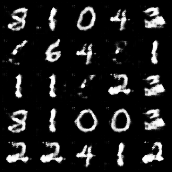

In [48]:
print(gen_labels.argmax(1))
Image.open("sample_images/final.png")